In [ ]:
import pandas as pd

# Load the CSV files
df1 = pd.read_csv('labeled_addresses_days_balance.csv')
df2 = pd.read_csv('labeled_addresses_transaction_counts.csv')

# Merge the DataFrames vertically
merged_df = pd.concat([df1, df2], axis=1)

# Remove duplicate 'address' columns, keeping only the first one
if merged_df.columns.duplicated().any():
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Drop rows where either 'first_days_ago' or 'latest_days_ago' is NaN
cleaned_df = merged_df.dropna(subset=['first_days_ago', 'latest_days_ago'])

# Convert 'first_days_ago' and 'latest_days_ago' to integers
cleaned_df['first_days_ago'] = cleaned_df['first_days_ago'].astype(int)
cleaned_df['latest_days_ago'] = cleaned_df['latest_days_ago'].astype(int)

# Compute the difference and name it 'active_days'
cleaned_df['active_days'] = cleaned_df['first_days_ago'] - cleaned_df['latest_days_ago']

# Drop the 'latest_days_ago' and 'first_days_ago' columns
cleaned_df = cleaned_df.drop(columns=['first_days_ago', 'latest_days_ago'])

# Save the resulting DataFrame to a new CSV file
cleaned_df.reset_index(drop=True)

/tmp/ipykernel_2307/4183761864.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['first_days_ago'] = cleaned_df['first_days_ago'].astype(int)
/tmp/ipykernel_2307/4183761864.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['latest_days_ago'] = cleaned_df['latest_days_ago'].astype(int)
/tmp/ipykernel_2307/4183761864.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,address,eth_balance,label,outTxn,inTxn,active_days
0,0x00192fb10df37c9fb26829eb2cc623cd1bf599e8,0.788607,0,59086,4645713,1704
1,0x002e08000acbbae2155fab7ac01929564949070d,0.045030,0,8937,59188,1703
2,0x004e6f03648b0b0f529511697b0f36a463a24836,2.379994,0,243,9208,267
3,0x0068eb681ec52dbd9944517d785727310b494575,0.000000,0,449,791,1090
4,0x00832a758a781055ac19b5f9bf553db8bb9db32d,0.000000,0,2124,61,724
...,...,...,...,...,...,...
496,0xfd648cc72f1b4e71cbdda7a0a91fe34d32abd656,0.102330,0,1892,2337,999
497,0xfdb16996831753d5331ff813c29a93c76834a0ad,0.016191,0,1004803,3612420,2381
498,0xfe95e04a628087fcdd5f278e61f148b47471af4a,1.406622,0,6345,464,1388
499,0xfe9e8709d3215310075d67e3ed32a380ccf451c8,0.082052,0,25012,1085,1174


In [ ]:
cleaned_df[["address", "label"]].to_csv('labeled_addresses_null_dropped.csv', index=False)

In [9]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Select features and target
X = cleaned_df[['eth_balance', 'outTxn', 'inTxn', 'active_days']]  # Features
y = cleaned_df['label']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': list(range(1, 51)),          # Number of trees 
    'min_samples_split': list(range(2, 11)),         # Minimum samples required to split a node
    'class_weight': [{0: 1, 1: 2}]  # Class weights
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',  # Focus on improving recall
    cv=5,              # 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available cores
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_text = classification_report(y_test, y_pred)

# Print results
print("Best Hyperparameters:", grid_search.best_params_)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report_text)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best Hyperparameters: {'class_weight': {0: 1, 1: 2}, 'min_samples_split': 9, 'n_estimators': 36}

Confusion Matrix:
 [[53  6]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        59
           1       0.88      1.00      0.93        42

    accuracy                           0.94       101
   macro avg       0.94      0.95      0.94       101
weighted avg       0.95      0.94      0.94       101




Feature Importance and Class Statistics:
        Feature  Importance   Class_0_Mean  Class_1_Mean     Difference
2        inTxn    0.491499  725564.549296     18.550802 -725545.998494
1       outTxn    0.308885  291542.553991     40.106952 -291502.447039
3  active_days    0.177535    1433.859155    201.893048   -1231.966107
0  eth_balance    0.022081      17.320059      0.006512     -17.313547


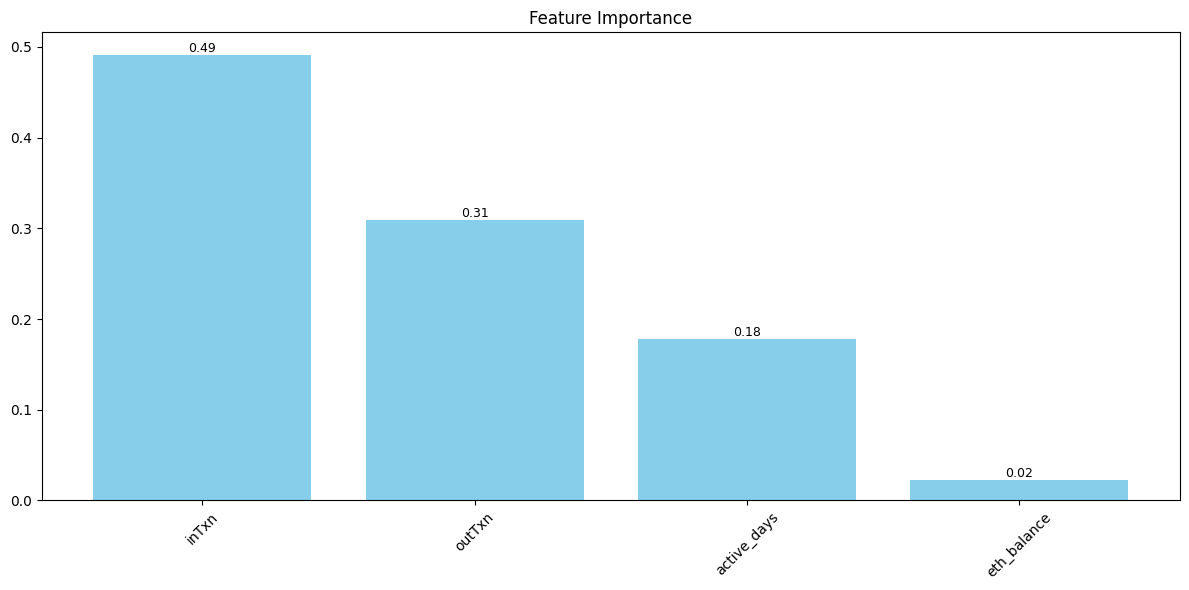

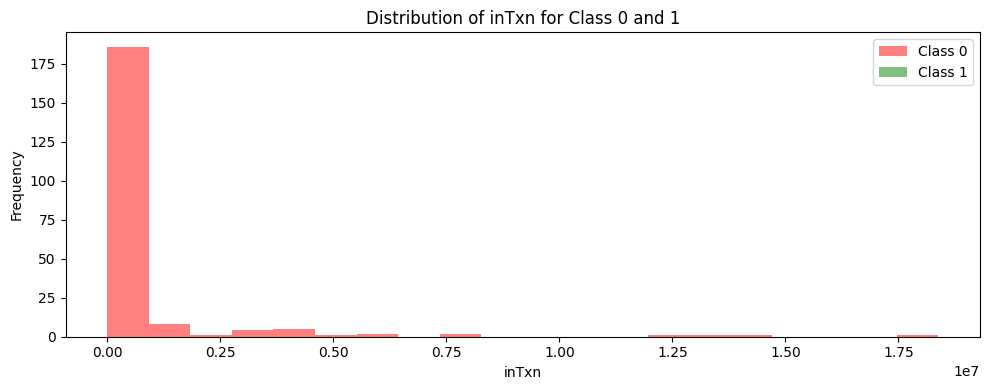

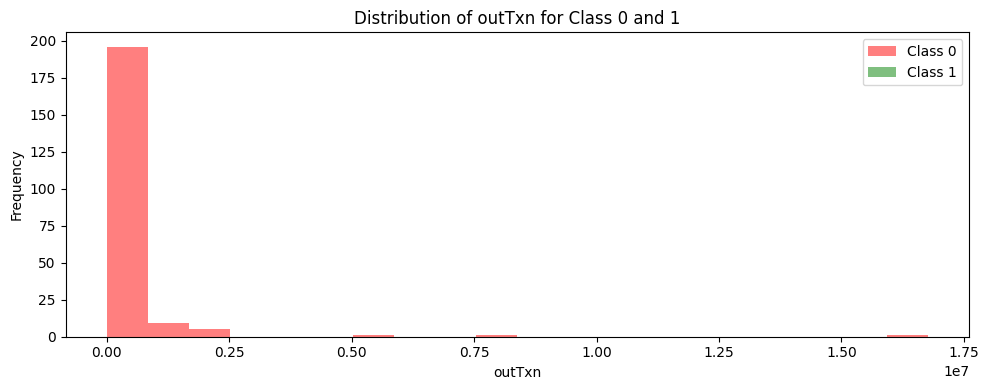

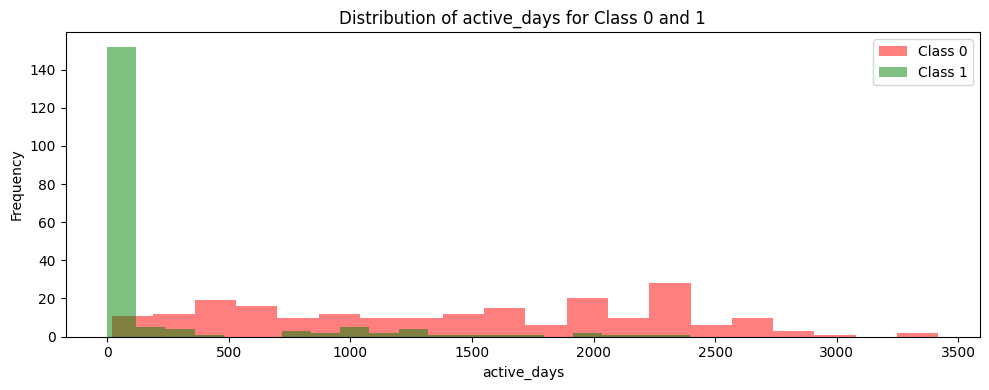

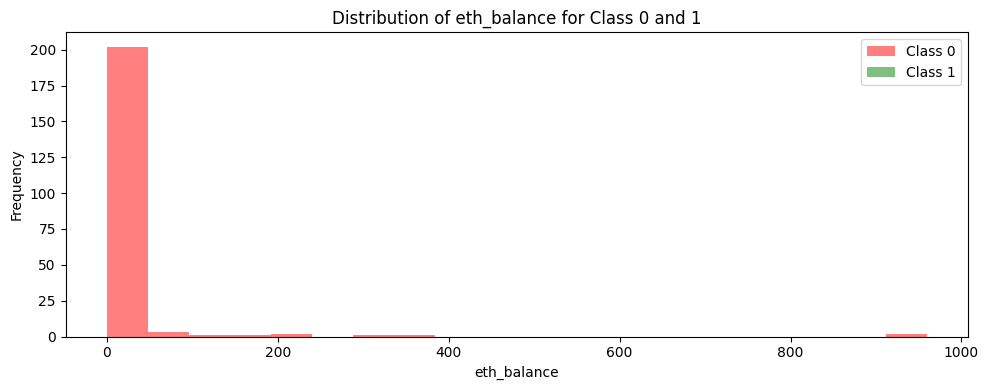

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for visualization and analysis
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Calculate the mean value of each feature for both classes (0 and 1)
class_0_mean = X_train[y_train == 0].mean()
class_1_mean = X_train[y_train == 1].mean()

# Add the class-specific means and the difference to the importance DataFrame
importance_df['Class_0_Mean'] = class_0_mean.loc[importance_df['Feature']].values
importance_df['Class_1_Mean'] = class_1_mean.loc[importance_df['Feature']].values
importance_df['Difference'] = importance_df['Class_1_Mean'] - importance_df['Class_0_Mean']

# Display the feature importance and class statistics
print("\nFeature Importance and Class Statistics:\n", importance_df)

# Plot the feature importance
plt.figure(figsize=(12, 6))
bars = plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')

# Annotate the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Visualize the distribution of each important feature for both classes
top_features = importance_df.head(5)['Feature']
for feature in top_features:
    plt.figure(figsize=(10, 4))
    plt.hist(X_train[y_train == 0][feature], bins=20, alpha=0.5, label='Class 0', color='red')
    plt.hist(X_train[y_train == 1][feature], bins=20, alpha=0.5, label='Class 1', color='green')
    plt.title(f'Distribution of {feature} for Class 0 and 1')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

Feature Importances:
        Feature  Importance
2        inTxn    0.491499
1       outTxn    0.308885
3  active_days    0.177535
0  eth_balance    0.022081


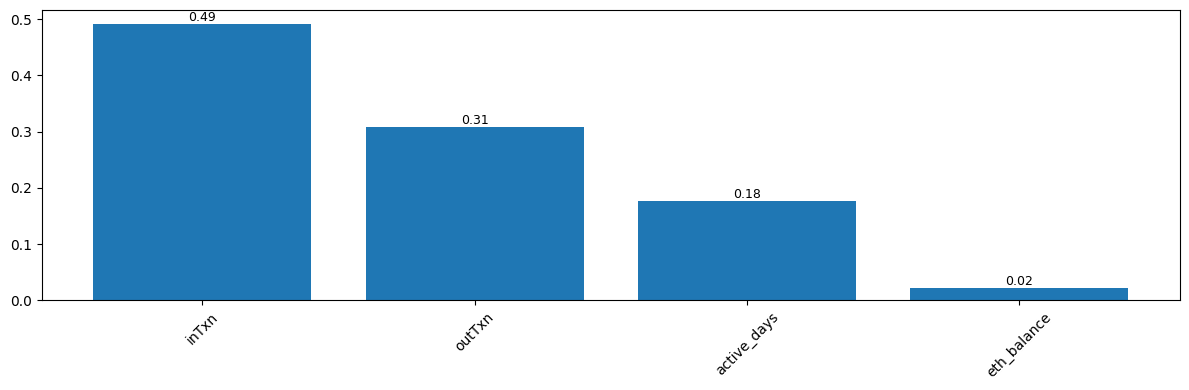

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:\n", importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 4))
bars = plt.bar(importance_df['Feature'], importance_df['Importance'], align='center')

# Annotate bars with numerical values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np

# Select features and target
X = cleaned_df[['eth_balance', 'outTxn', 'inTxn', 'active_days']]  # Features
y = cleaned_df['label']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV (similar to Random Forest)
param_grid = {
    'n_estimators': list(range(1, 31)),          # Number of trees 
    'learning_rate': np.arange(0.1, 0.6, 0.1).tolist(),
    'gamma': np.arange(0.1, 0.6, 0.1).tolist(),
}

# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',  # Focus on improving recall
    cv=5,              # 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available cores
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_text = classification_report(y_test, y_pred)

# Print results
print("Best Hyperparameters:", grid_search.best_params_)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report_text)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


/home/yevadrian/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:47:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yevadrian/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:47:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yevadrian/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:47:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yevadrian/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:47:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yevadrian/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:47:31] WARNING

Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.2, 'n_estimators': 20}

Confusion Matrix:
 [[55  4]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        59
           1       0.91      1.00      0.95        42

    accuracy                           0.96       101
   macro avg       0.96      0.97      0.96       101
weighted avg       0.96      0.96      0.96       101




Feature Importance and Class Statistics:
        Feature  Importance   Class_0_Mean  Class_1_Mean     Difference
2        inTxn    0.715994  725564.549296     18.550802 -725545.998494
1       outTxn    0.121360  291542.553991     40.106952 -291502.447039
3  active_days    0.106815    1433.859155    201.893048   -1231.966107
0  eth_balance    0.055830      17.320059      0.006512     -17.313547


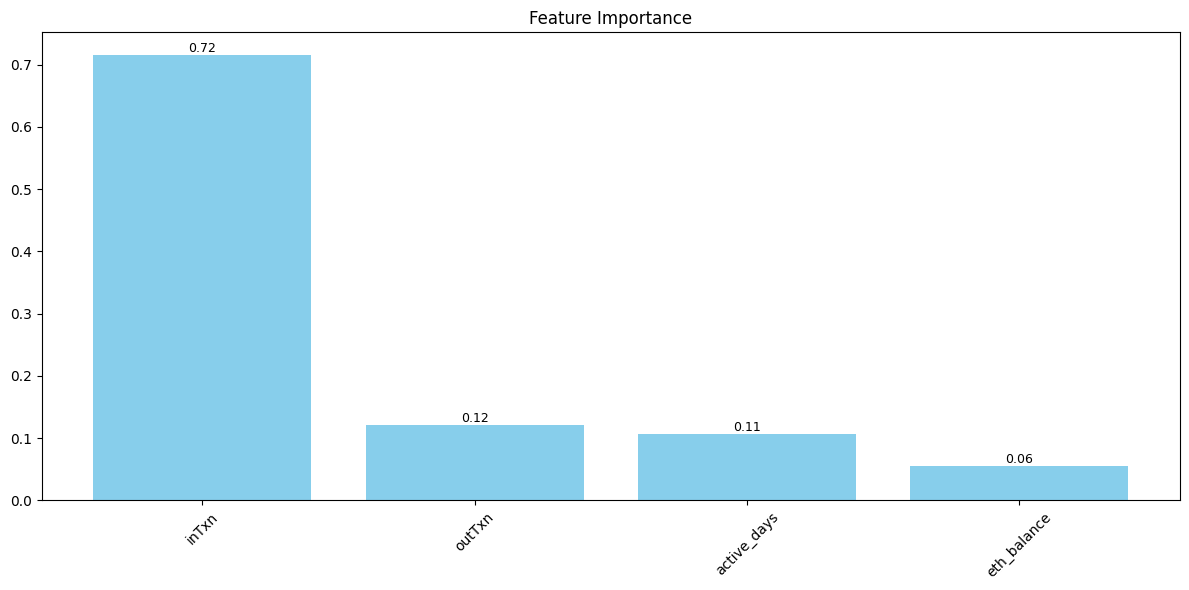

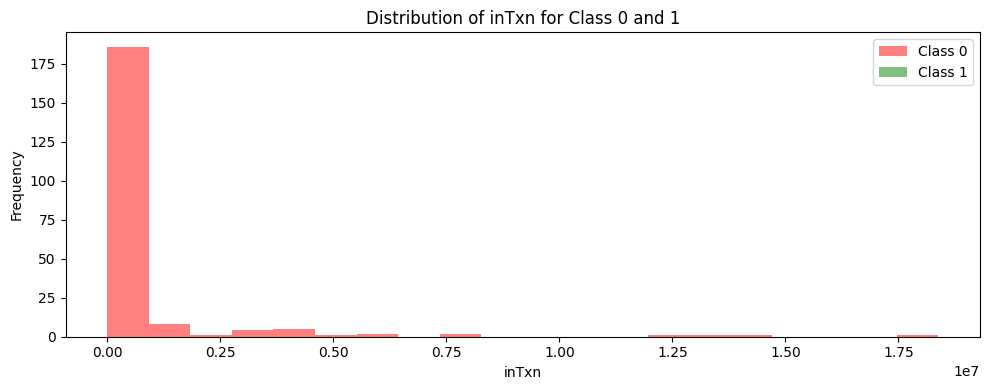

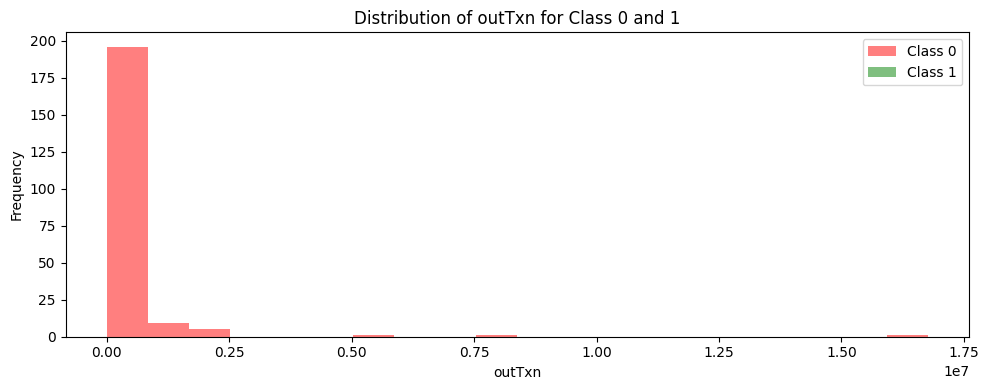

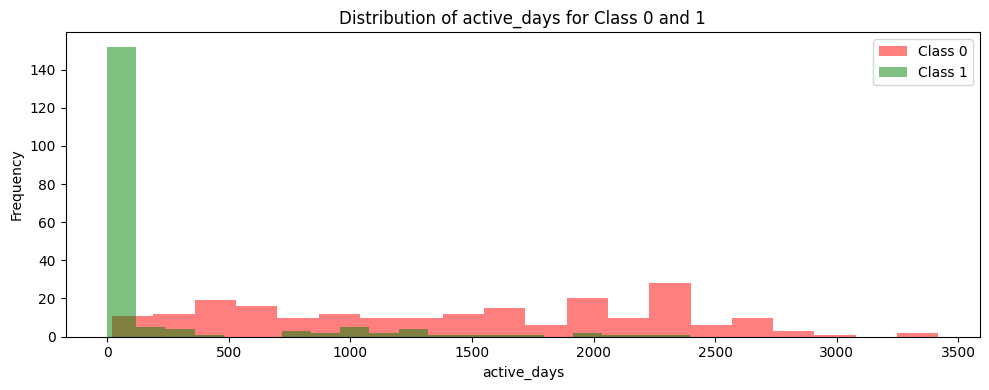

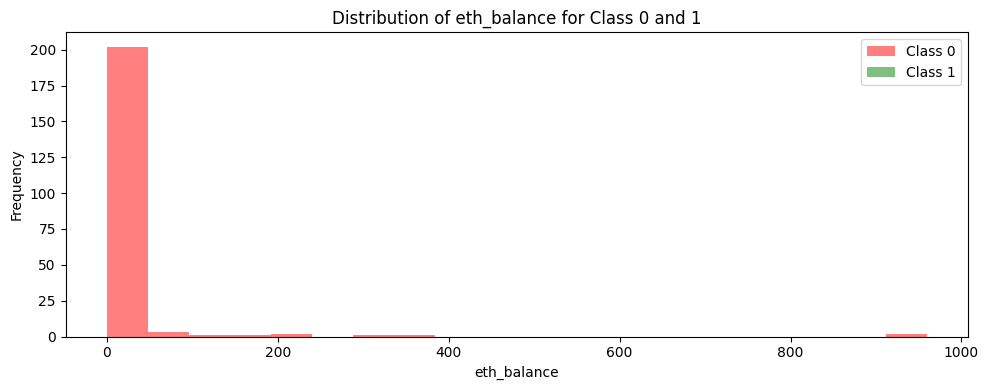

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for visualization and analysis
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Calculate the mean value of each feature for both classes (0 and 1)
class_0_mean = X_train[y_train == 0].mean()
class_1_mean = X_train[y_train == 1].mean()

# Add the class-specific means and the difference to the importance DataFrame
importance_df['Class_0_Mean'] = class_0_mean.loc[importance_df['Feature']].values
importance_df['Class_1_Mean'] = class_1_mean.loc[importance_df['Feature']].values
importance_df['Difference'] = importance_df['Class_1_Mean'] - importance_df['Class_0_Mean']

# Display the feature importance and class statistics
print("\nFeature Importance and Class Statistics:\n", importance_df)

# Plot the feature importance
plt.figure(figsize=(12, 6))
bars = plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')

# Annotate the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Visualize the distribution of each important feature for both classes
top_features = importance_df.head(5)['Feature']
for feature in top_features:
    plt.figure(figsize=(10, 4))
    plt.hist(X_train[y_train == 0][feature], bins=20, alpha=0.5, label='Class 0', color='red')
    plt.hist(X_train[y_train == 1][feature], bins=20, alpha=0.5, label='Class 1', color='green')
    plt.title(f'Distribution of {feature} for Class 0 and 1')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

Feature Importances:
        Feature  Importance
2        inTxn    0.715994
1       outTxn    0.121360
3  active_days    0.106815
0  eth_balance    0.055830


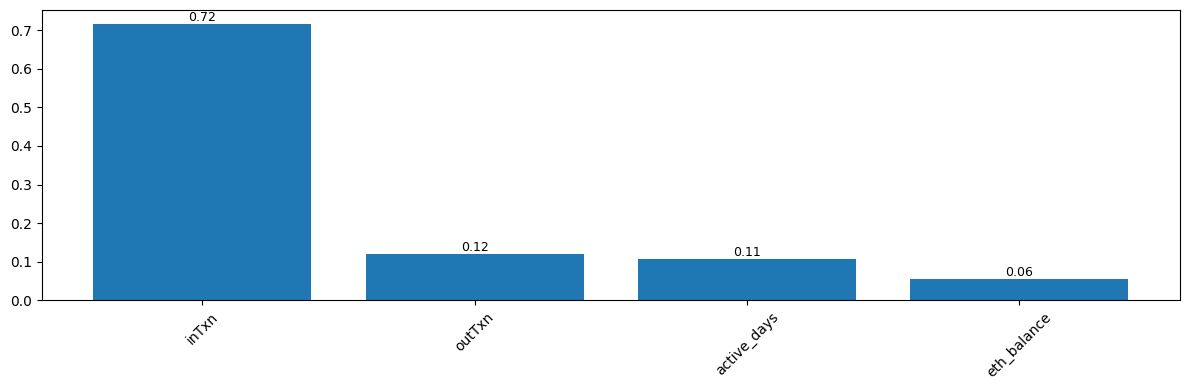

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:\n", importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 4))
bars = plt.bar(importance_df['Feature'], importance_df['Importance'], align='center')

# Annotate bars with numerical values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Summary Statistics for Active Days by Label:
        count         mean         std   min    25%     50%      75%     max
label                                                                      
0      272.0  1437.389706  809.042326  16.0  694.5  1426.5  2148.75  3418.0
1      229.0   193.209607  469.063101   0.0    0.0     1.0    64.00  2396.0

Mean Active Days:
  Licit (Label 0): 1437.39
  Illicit (Label 1): 193.21


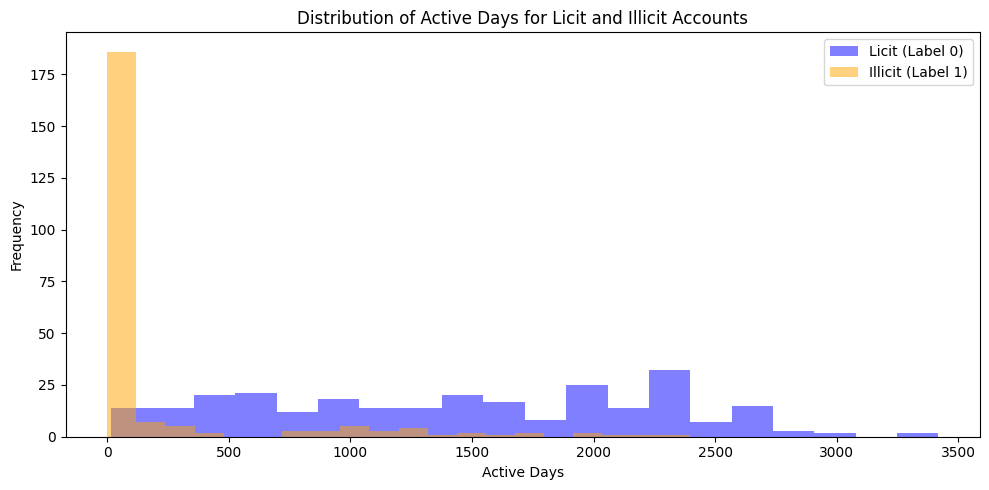

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cleaned_df contains the original dataset with 'active_days' and 'label'
# Filter out licit (label = 0) and illicit (label = 1) data
licit_data = cleaned_df[cleaned_df['label'] == 0]
illicit_data = cleaned_df[cleaned_df['label'] == 1]

# Summary statistics for 'active_days'
active_days_stats = cleaned_df.groupby('label')['active_days'].describe()
print("\nSummary Statistics for Active Days by Label:\n", active_days_stats)

# Calculate and print mean active days for both classes
licit_mean_days = licit_data['active_days'].mean()
illicit_mean_days = illicit_data['active_days'].mean()
print(f"\nMean Active Days:\n  Licit (Label 0): {licit_mean_days:.2f}\n  Illicit (Label 1): {illicit_mean_days:.2f}")

# Visualize the distribution of active days for both labels
plt.figure(figsize=(10, 5))
plt.hist(licit_data['active_days'], bins=20, alpha=0.5, label='Licit (Label 0)', color='blue')
plt.hist(illicit_data['active_days'], bins=20, alpha=0.5, label='Illicit (Label 1)', color='orange')
plt.title('Distribution of Active Days for Licit and Illicit Accounts')
plt.xlabel('Active Days')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

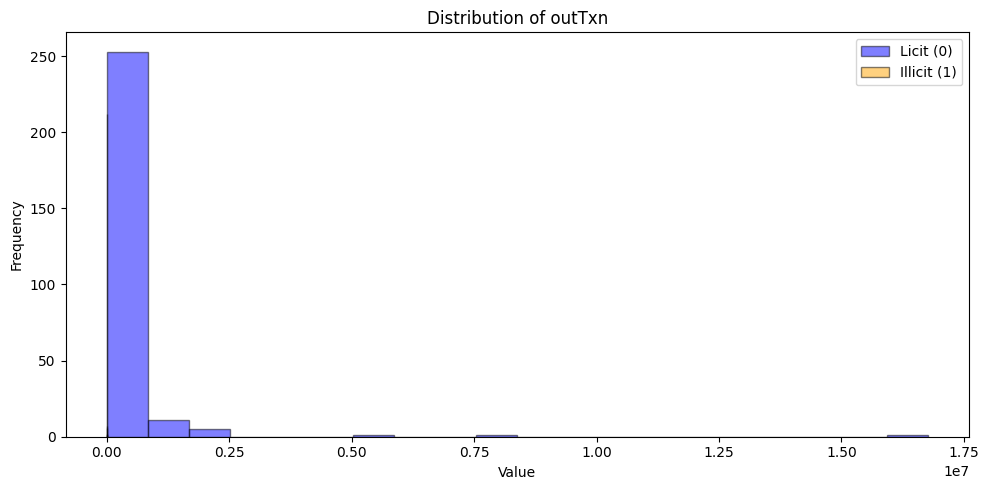

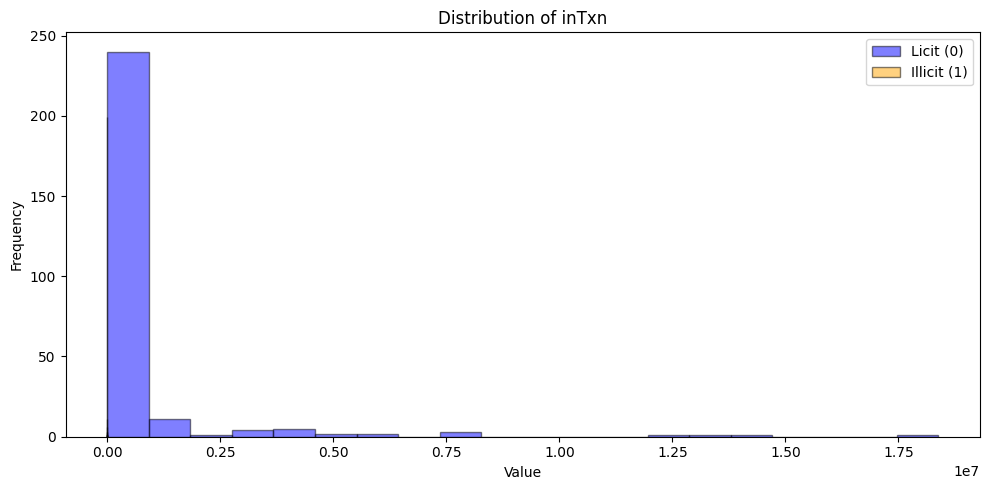

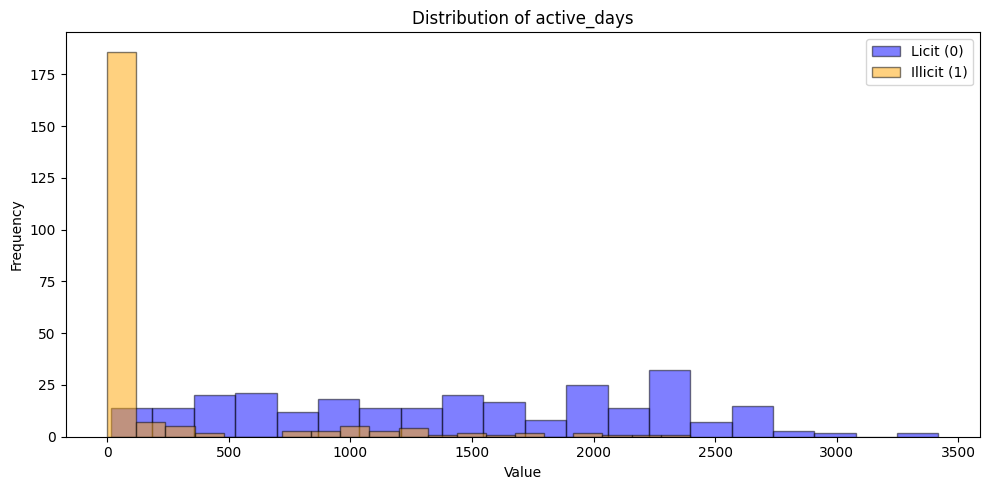

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter licit and illicit data
licit_data = cleaned_df[cleaned_df['label'] == 0]
illicit_data = cleaned_df[cleaned_df['label'] == 1]

# Function to plot feature distribution
def plot_distribution(feature_name):
    plt.figure(figsize=(10, 5))
    
    # Plot histograms for licit and illicit data
    plt.hist(licit_data[feature_name], bins=20, alpha=0.5, label='Licit (0)', color='blue', edgecolor='black')
    plt.hist(illicit_data[feature_name], bins=20, alpha=0.5, label='Illicit (1)', color='orange', edgecolor='black')

    # Set title and labels
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Plot distributions for each feature
plot_distribution('outTxn')
plot_distribution('inTxn')
plot_distribution('active_days')

In [21]:
# Calculate averages for 'outTxn', 'inTxn', and 'active_days' for both labels
average_values = {
    'Licit (Label 0)': cleaned_df[cleaned_df['label'] == 0][['outTxn', 'inTxn', 'active_days']].mean(),
    'Illicit (Label 1)': cleaned_df[cleaned_df['label'] == 1][['outTxn', 'inTxn', 'active_days']].mean()
}

# Display the result
print("\nAverage values for each feature:")
print(pd.DataFrame(average_values))


Average values for each feature:
             Licit (Label 0)  Illicit (Label 1)
outTxn         246785.606618          37.829694
inTxn          646861.915441          18.021834
active_days      1437.389706         193.209607
